In [1]:
import sys, os
import xsimlab as xs
import xarray as xa
import pandas as pd
import numpy as np
import sparse
import igraph as ig
import ipywidgets as widgets

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import carbon_unit

model = fruit_model.drop_processes(['carbon_unit', 'light', 'photo', 'carbon', 'fruit_quality', 'fruit_growth', 'pheno_flower', 'pheno_leaf'])
#model = fruit_model.update_processes({ 'carbon_unit': carbon_unit.JustOne })
model

<xsimlab.Model (7 processes, 7 inputs)>
params
    path                     [in]
    seed                     [in]
env
topo
    is_apical             [inout] ('GU',) 
    adjacency             [inout] ('GU', 'GU') 
    nb_leaves_gu          [inout] ('GU',) 
pheno_gu
inflo_growth
gu_growth
gu_burst
    gu_bursted            [inout] ('GU',) 
    gu_bursted_is_apical  [inout] ('GU',) 

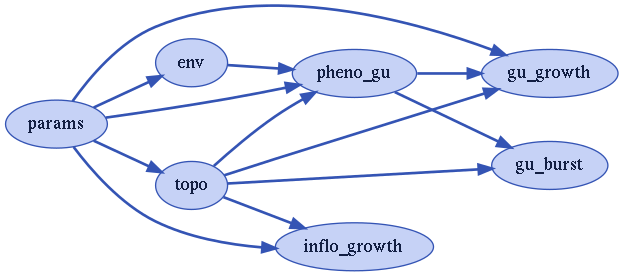

In [3]:
model.visualize(show_inputs=False, show_variables=False)

In [4]:
ds = vmlab.create_setup(
    model=model,
    clocks={
        'day': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1d"),
        'week': pd.date_range(start='2002-09-02', end='2003-03-28', freq="1W")
    },
    master_clock='day',
    input_vars={
        'params': {
            'seed': 0,
            'path': '../share/setup/default.toml'
        },
        'gu_burst': {
            'gu_bursted': [False, False, False, False, False, False, False],
            'gu_bursted_is_apical': [False, False, False, False, False, False, False]
        },
        'topo': {
            'adjacency': sparse.COO(np.array([
                    [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6]
                ]).transpose(), True, shape=(7, 7)),
            'is_apical': [False, False, False, True, False, False, False],
            'nb_leaves_gu': [0, 5, 10, 25, 50, 100, 150]
        }
    },
    output_vars = {
        'topo': {
            'is_apical': 'day',
            'adjacency': 'day',
            'nb_leaves_gu': 'day'
        },
        'pheno_gu': {
            'gu_growth_tts': 'day',
            'gu_stage': 'day'
        },
        'gu_burst': {
            'gu_bursted': 'day',
            'gu_bursted_is_apical': 'day'
        }
    }
)

In [5]:
ds

Format,coo
Data Type,bool
Shape,"(7, 7)"
nnz,6
Density,0.12244897959183673
Read-only,True
Size,102
Storage ratio,2.1


In [6]:
out = widgets.Output(layout=widgets.Layout(width='100%', height='800px'))
stage_color = {'A':'grey', 'B':'green', 'C':'yellow', 'D':'orange'}
@xs.runtime_hook('run_step')
def runtime_hook(model, context, state):
    if context['step'] % 7 == 0 or context['step'] == context['nsteps'] - 1:
        GU = state[('topo', 'GU')]
        adjacency = state[('topo', 'adjacency')]
        is_apical = state[('topo', 'is_apical')]
        gu_growth_tts = state[('pheno_gu', 'gu_growth_tts')]
        gu_stage = state[('pheno_gu', 'gu_stage')]
        g = ig.Graph.Adjacency(list(np.ones(adjacency.shape) * adjacency))
        l = g.layout_reingold_tilford(root=0)
        l.rotate(-90)
        style = {
            'vertex_size': 7,
            'vertex_color': [stage_color[s] for s in gu_stage],
            'vertex_label_size': 15,
            #'vertex_label': [int(t) for s,t in zip(gu_stage, gu_growth_tts)],
            'edge_arrow_size': 0,
            'edge_arrow_width': 1
        }
        with out:
            out.clear_output()
            print(context['step'] + 1, '/' ,context['nsteps'], 'GU:', GU.shape[0])
            display(ig.plot(g, layout=l, bbox = (800, 500), margin=(20, 20, 20, 20), **style))
out

Output(layout=Layout(height='800px', width='100%'))

In [7]:
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[runtime_hook])

In [8]:
ds_out

<xarray.Dataset>
Dimensions:                         (GU: 771, day: 208, hour: 24, week: 29)
Coordinates:
  * GU                              (GU) <U10 'GU0' 'GU1' ... 'GU769' 'GU770'
  * day                             (day) datetime64[ns] 2002-09-02 ... 2003-...
  * hour                            (hour) int8 0 1 2 3 4 5 ... 19 20 21 22 23
  * week                            (week) datetime64[ns] 2002-09-08 ... 2003...
Data variables:
    gu_burst__gu_bursted            (day, GU) bool False False ... False False
    gu_burst__gu_bursted_is_apical  (day, GU) bool False False ... False False
    params__path                    <U27 '../share/setup/default.toml'
    params__seed                    int64 0
    pheno_gu__gu_growth_tts         (day, GU) float64 12.4 12.4 ... 15.65 15.65
    pheno_gu__gu_stage              (day, GU) <U1 'A' 'A' 'A' ... 'A' 'A' 'A'
    topo__adjacency                 (day, GU, GU) bool False True ... False
    topo__is_apical                 (day, GU) bool False False ... True True
    topo__nb_leaves_gu              (day, GU) int64 0 5 10 25 50 ... 0 0 0 0 0

In [9]:
#ds_out.carbon_unit__dd_cum.plot.line(x='day')

In [10]:
#ds_out.plot.scatter(x='carbon_unit__dd_cum', y='carbon__DM_fruit', col='CU', col_wrap=3)

In [11]:
#ds_out.light__LFratio.plot()

In [12]:
#ds_out.carbon_unit__nb_leaves.plot()

In [13]:
#ds_out.carbon_unit__nb_fruits.plot()



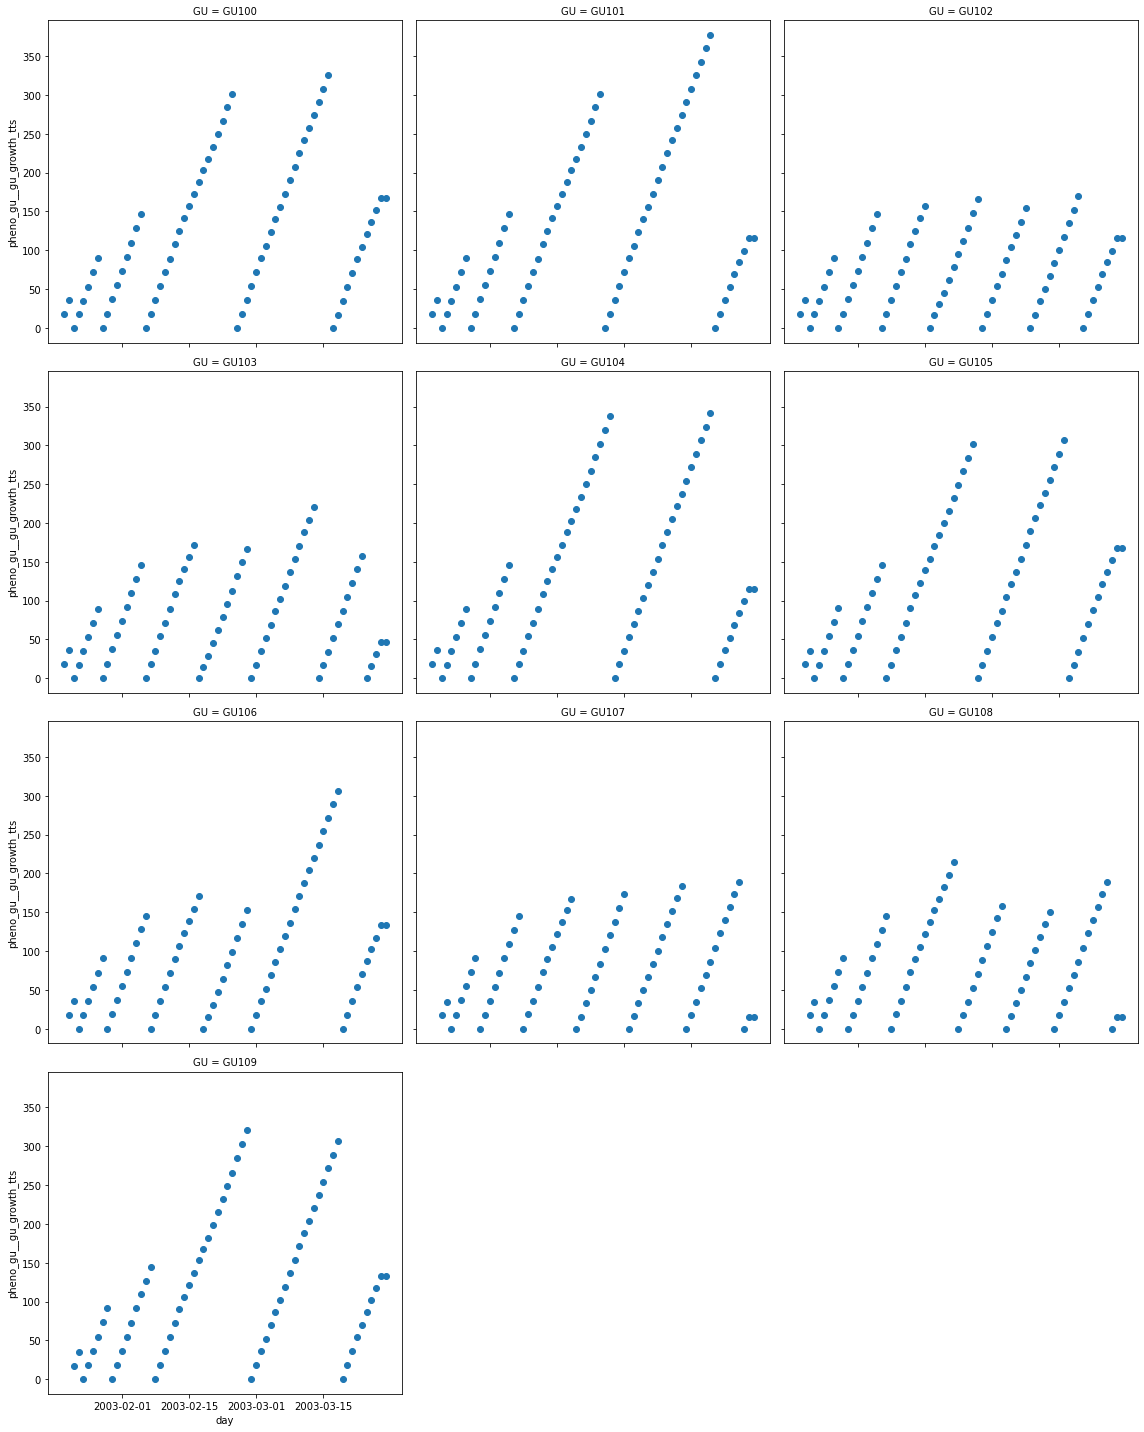

In [14]:
ds_out[['pheno_gu__gu_growth_tts']].isel({'GU': slice(100,110) }).plot.scatter(x='day', y='pheno_gu__gu_growth_tts', col='GU', col_wrap=3, size=5)

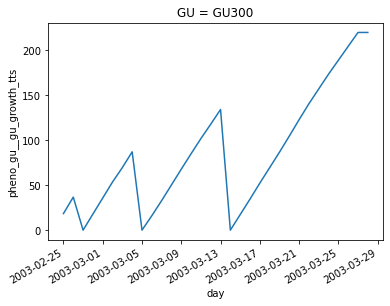

In [22]:
ds_out.pheno_gu__gu_growth_tts[:,300].plot.line()

In [30]:
ds_out[['pheno_gu__gu_growth_tts', 'pheno_gu__gu_stage', 'topo__is_apical']].to_dataframe()

pheno_gu__gu_growth_tts pheno_gu__gu_stage  topo__is_apical
GU    day                                                                    
GU0   2002-09-02                    12.40                  A            False
      2002-09-03                    24.10                  A            False
      2002-09-04                    36.15                  A            False
      2002-09-05                    48.85                  A            False
      2002-09-06                     0.00                  B            False
...                                   ...                ...              ...
GU770 2003-03-24                      NaN                               False
      2003-03-25                      NaN                               False
      2003-03-26                      NaN                               False
      2003-03-27                    15.65                  A             True
      2003-03-28                    15.65                  A             True

[160368 rows x 3 columns]